<a href="https://colab.research.google.com/github/LawsonHutter/RNN_working_memory/blob/main/RNN_working_memory_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# Set some properties of the model. We'll store these in a dict so they're
# easier to pass around or save.
model = {}

# properties of the recurrent pool:
model['N'] = 1000  # number of neurons
model['g'] = 0.95  # gain of synaptic weights in pool
model['sp'] = 0.25  # fraction of weights that are nonzero
model['tau'] = 20  # neural membrane time constant in ms
model['dt'] = 0.1  # simulation timestep in ms
model['nonlin'] = lambda x: np.tanh(x)  # firing rate nonlinearity for pool units

# properties of the input layer:
# a note: we're going to encode the "value" of the input by the identity of the
# active input layer units. We'll use one-hot encoding: for each input step
# during simulation, one unit will be activated with "firing rate" 1, and the
# rest will be set to firing rate 0 (adjust gIn to change the scaling of input
# to the recurrent pool.)
# Note 1: This is just one way of setting up input- are there other approaches
# that would improve memory capacity?
# Note 2: Burn-in time is especially important if your model has g>1, in which
# case neurons will be spontaneously active.
model['nIn'] = 20  # size of the input layer
model['gIn'] = 10.0  # gain of the input weights
model['spIn'] = 0.05  # sparsity of input->pool connectivity
model['burnIn'] = 10  # time before input starts
model['durIn'] = 1  # time for which an input is active in ms
model['ISI'] = 0  # time between inputs in ms
model['nonlinIn'] = lambda x: x  # best to keep the input linear

In [4]:
# Create the synaptic weight matrix.
# Normalizing weights by sqrt(N*sparsity) keeps the eigenvalue spectrum
# invariant to the size of the population N.
randMat  = np.random.normal(0, 1, size=(model['N'], model['N']))
spMat  = np.random.uniform(0, 1, size=(model['N'], model['N'])) <= model['sp']
model['J'] = np.multiply(randMat, spMat) * model['g'] / math.sqrt(model['N'] * model['sp'])

# Create the input weight matrix.
randMatIn = np.random.normal(0, 1, size=(model['N'], model['nIn']))
spMatIn = np.random.uniform(0, 1, size=(model['N'], model['nIn'])) <= model['spIn']
model['Jin'] = np.multiply(randMatIn, spMatIn) * model['gIn'] / math.sqrt(model['nIn'] * model['spIn'])

In [5]:
# Define a couple helper functions for simulation.

def step(firing_rates, input_layer, model):
  # The simulation function. We use Euler's method to simulate the evolution of
  # model neuron firing rates given the input_layer firing rates.

  timestep = math.exp(-model['dt']/model['tau'])
  vIn = np.matmul(model['J'], firing_rates) \
        + np.matmul(model['Jin'], model['nonlinIn'](input_layer))
  updated_rates = model['nonlin'](vIn + (firing_rates - vIn) * timestep)

  return updated_rates


def make_input(sequence_length, model):
  # Generates a sequence of inputs according to the parameters in model. Returns
  # the sequence both as a one-hot encoding and as a sequence of integer values.

  input_stream = [0] * int(model['burnIn']/model['dt'])

  for i in range(sequence_length):
    val = np.random.randint(0, model['nIn']) + 1
    for t in range(int(model['ISI']/model['dt'])):
      input_stream.append(0.0)
    for t in range(int(model['durIn']/model['dt'])):
      input_stream.append(val)

  input_stream = np.array(input_stream)

  onehot = np.zeros((model['nIn'] + 1, input_stream.size))
  onehot[input_stream, np.arange(input_stream.size)] = 1.0
  onehot = onehot[1:, :]

  return onehot, input_stream

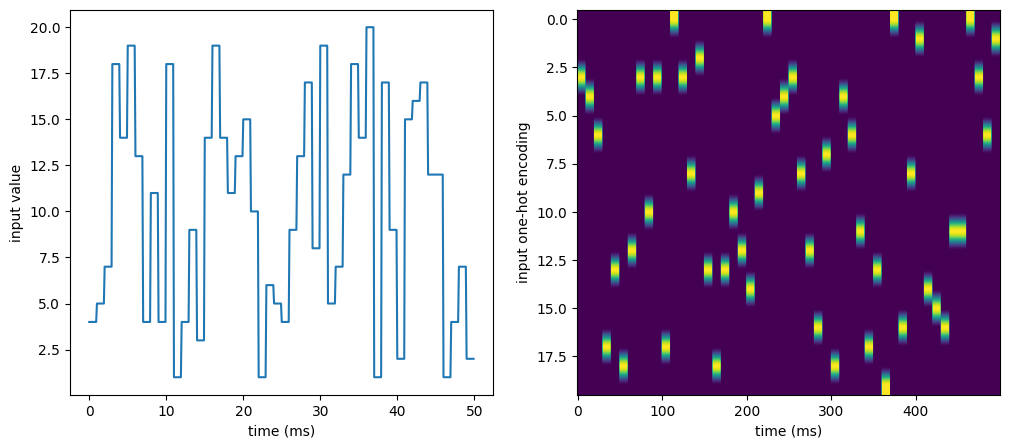

In [6]:
# Look at an example input stream.

onehot, stream = make_input(50, model)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
omit = int(model['burnIn']/model['dt']) # don't plot the burn-in period
ax[0].plot(np.arange(len(stream) - omit) * model['dt'], stream[omit:])
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('input value')

ax[1].imshow(onehot[:, omit:], aspect='auto')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input one-hot encoding')
fig.show()

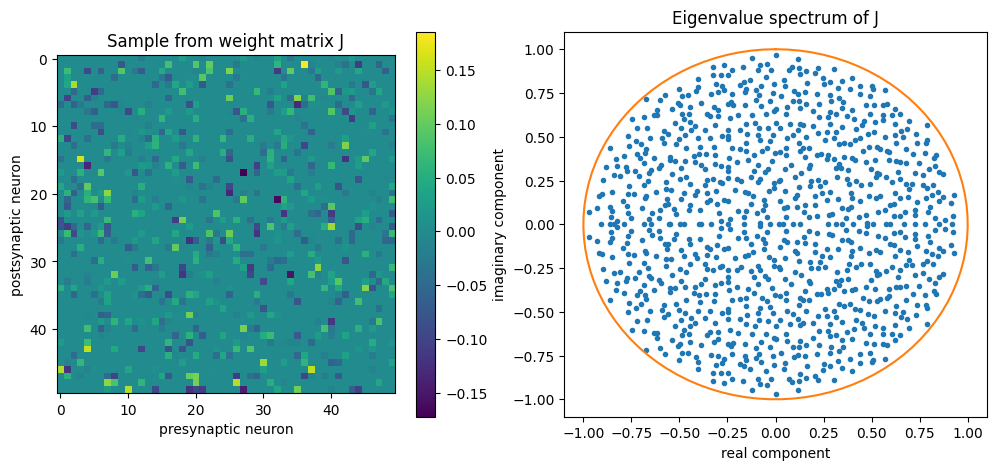

In [7]:
# Take a look at the eigenvalue spectrum of J.
w, v = np.linalg.eig(model['J'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
showCount = 50  # portion of J to actually show (for readability)
h = ax[0].imshow(model['J'][:showCount,:showCount])
ax[0].set_title('Sample from weight matrix J')
ax[0].set_xlabel('presynaptic neuron')
ax[0].set_ylabel('postsynaptic neuron')
plt.colorbar(h, ax=ax[0])

ax[1].plot(np.real(w),np.imag(w),'.')
ax[1].plot(np.sin(np.linspace(0,2*math.pi,100)),
           np.cos(np.linspace(0,2*math.pi,100)))  # circle with radius 1
ax[1].set_title('Eigenvalue spectrum of J')
ax[1].set_xlabel('real component')
ax[1].set_ylabel('imaginary component')
fig.show()

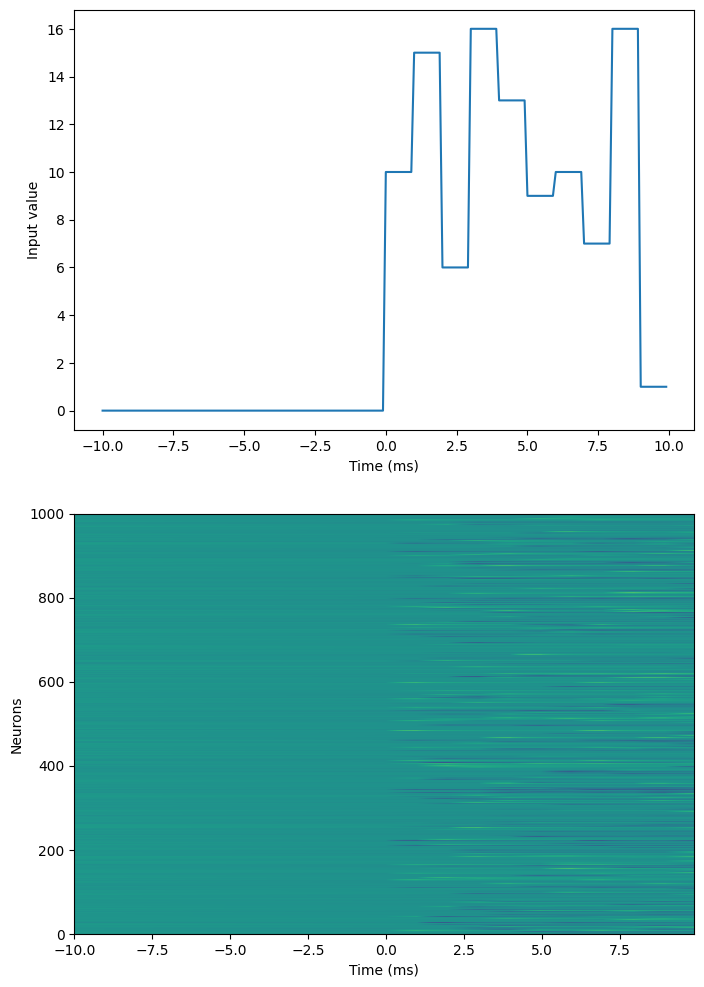

In [8]:
# Simulate the model activity.

# generate the input to the model
onehot, input_stream = make_input(10, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(input_stream)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(input_stream)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)


fig, ax = plt.subplots(2, 1, figsize=(8, 12))
simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']
ax[0].plot(simulation_time, input_stream)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Input value')

extents = [simulation_time[0],simulation_time[-1], 0, model['N']]
ax[1].imshow(firing_rates, aspect='auto', extent=extents)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Neurons')
fig.show()

In [52]:
# Our Imports
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Generate a set of input sequences and corresponding firing rate sequences
sequence_length = 100
onehot, inputs = make_input(sequence_length, model)

# initialize the firing rates randomly
firing_rates = np.zeros((model['N'], len(inputs)))
firing_rates[:, 0] = np.random.uniform(0, 0.1, size=(model['N']))

for t in range(len(inputs)-1):
  firing_rates[:,t+1] = step(firing_rates[:,t], onehot[:,t], model)

simulation_time = np.arange(len(input_stream))*model['dt'] - model['burnIn']

In [ ]:
# Useful Shapes
print("inputs shape")
print(inputs.shape)

print("firing_rates shape")
print(firing_rates.shape)

print("simulation_time shape")
print(simulation_time.shape)

inputs shape
(1100,)
firing_rates shape
(1000, 1100)
simulation_time shape
(200,)


In [10]:
firing_rates.T.shape

(1100, 1000)

Q1)

In [11]:
# Define the maximum value of X to consider
max_X = 5

In [22]:
# Build Model Here
"""
Assumptions / Decisions:

Using a RNN because that seems to be the nature of this assignment
For a decoder, I am assuming the architecture should be 'many to one'
I am unsure of how to incorporate the g parameter.  I am assuming it means gain

"""

# Some declarations
rates = firing_rates.T
input = inputs
max_X = 5

input_size = 1000 # Firing rates of all neurons
output_size = 1 # 1 scaler value 
g = 1 # gain parameter from assignment

# Define an RNN model with a single LSTM layer
class WorkingMemoryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g):
        super(WorkingMemoryRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.g = g
    
    def forward(self, x):
        batch_size, seq_len, input_size = x.shape
        
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        out, h = self.rnn(x, h0)
        
        out = self.fc(out[:, -1, :])
        
        out = out * self.g
        
        return out

In [32]:
# Generate data

X_train_set = []
X_test_set = []
y_train_set = []
y_test_set = []

for x in range(0, max_X):

    # Create the training and test sets for the current X value
    X_all = []
    Y_all = []

    for t in range(x, 1100):
        # Create the input window by taking the firing rates at time t and the previous time steps
        X_input = rates[t, :]

        # Create the target by taking the input at time t-X
        y_target = input[t-x]

        X_all.append(X_input)
        Y_all.append(y_target)

    # Train test split
    X_all = np.array(X_all)
    Y_all = np.array(Y_all)

    X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

    # Append the current training and test sets to the list of sets
    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)

X_train_set = np.array(X_train_set)
X_test_set = np.array(X_test_set)
y_train_set = np.array(y_train_set)
y_test_set = np.array(y_test_set)

<ipython-input-32-9332e081fdf8>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_set = np.array(X_train_set)
<ipython-input-32-9332e081fdf8>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train_set = np.array(y_train_set)


In [37]:
print(X_train_set[0].shape[0])
print(y_train_set[0].shape)

880
(880,)


In [44]:
# Training

# Define hyperparameters
input_size = X_train_set[0].shape[0]
hidden_size = 64
output_size = 1
g = 1
learning_rate = 0.01
num_epochs = 50

# Create RNN model
model = WorkingMemoryRNN(input_size, hidden_size, output_size, g)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i in range(len(X_train_set[0])):
        # Forward pass
        outputs = model(X_train_set[i])
        loss = criterion(outputs, y_train_set[i])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Add current loss to running loss
        running_loss += loss.item()
    
    # Print average loss for current epoch
    avg_loss = running_loss / len(X_train_set[0])
    print(f"Epoch {epoch+1}: average loss = {avg_loss:.6f}")


ValueError: ignored

In [51]:
# Training (WORKING, need to nest this into a larger loop)

# Define hyperparameters
input_size = 1000
hidden_size = 64
output_size = 1
g = 1
learning_rate = 0.01
num_epochs = 50
batch_size = 32

# Create RNN model
model = WorkingMemoryRNN(input_size, hidden_size, output_size, g)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Split data into batches
    x_batches = torch.chunk(torch.from_numpy(X_train_set[0]).unsqueeze(0), batch_size, dim=0)
    y_batches = torch.chunk(torch.from_numpy(y_train_set[0]).unsqueeze(0), batch_size, dim=0)
    
    for x_batch, y_batch in zip(x_batches, y_batches):
        # Create input and target tensors
        inputs = x_batch.float()
        targets = y_batch.float()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Add current loss to running loss
        running_loss += loss.item()
    
    # Print average loss for current epoch
    avg_loss = running_loss / (len(X_train_set[0]) / batch_size)
    print(f"Epoch {epoch+1}: average loss = {avg_loss:.6f}")

Epoch 1: average loss = 5.290823
Epoch 2: average loss = 3.304376
Epoch 3: average loss = 2.782361
Epoch 4: average loss = 2.523179
Epoch 5: average loss = 2.309624
Epoch 6: average loss = 2.121438
Epoch 7: average loss = 1.958946
Epoch 8: average loss = 1.822339
Epoch 9: average loss = 1.711717
Epoch 10: average loss = 1.626764
Epoch 11: average loss = 1.566361
Epoch 12: average loss = 1.528490
Epoch 13: average loss = 1.510284
Epoch 14: average loss = 1.508165
Epoch 15: average loss = 1.518065
Epoch 16: average loss = 1.535726
Epoch 17: average loss = 1.557038
Epoch 18: average loss = 1.578365
Epoch 19: average loss = 1.596808
Epoch 20: average loss = 1.610359
Epoch 21: average loss = 1.617928
Epoch 22: average loss = 1.619271
Epoch 23: average loss = 1.614847
Epoch 24: average loss = 1.605623
Epoch 25: average loss = 1.592887
Epoch 26: average loss = 1.578066
Epoch 27: average loss = 1.562569
Epoch 28: average loss = 1.547662
Epoch 29: average loss = 1.534381
Epoch 30: average loss 

In [57]:
# Evaluate

# Set the model to evaluation mode
model.eval()

# Define the test set
X_test_set_ = X_test_set[0]
y_test_set_ = y_test_set[0]

# Define the batch size
batch_size = 32

# Define the loss function
criterion = nn.MSELoss()

# Define lists to store predictions and targets
all_predictions = []
all_targets = []

# Split data into batches
x_batches = torch.chunk(torch.from_numpy(X_test_set), batch_size, dim=0)
y_batches = torch.chunk(torch.from_numpy(y_test_set), batch_size, dim=0)

# Iterate over the batches
for x_batch, y_batch in zip(x_batches, y_batches):
    # Create input and target tensors
    inputs = x_batch.float()
    targets = y_batch.float()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Store predictions and targets
    all_predictions.extend(outputs.cpu().detach().numpy().tolist())
    all_targets.extend(targets.cpu().detach().numpy().tolist())

# Compute metrics
mse = mean_squared_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f"Mean squared error: {mse:.6f}")
print(f"R-squared score: {r2:.6f}")

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 220])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: ignored